In [ ]:
# Create Conditional Generative Adversarial Network (GAN) to generate new images of handwritten digits
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

# Reshape the images to (28, 28, 1)
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
sample_size = 100
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

2024-02-02 14:36:13.490686: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 14:36:13.490749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 14:36:13.492299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 14:36:13.504064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 14:36:15.289714: W tensorflow/compiler/tf2

In [2]:
# Create Generator model which uses conditional input

label = tf.keras.layers.Input(shape=(1,))
embed = tf.keras.layers.Embedding(10, 50)(label)
dense = tf.keras.layers.Dense(7 * 7)(embed)
reshape = tf.keras.layers.Reshape((7, 7, 1))(dense)

latent_input = tf.keras.layers.Input(shape=(100,))
x = tf.keras.layers.Dense(7 * 7 * 256)(latent_input)
x2 = tf.compat.v1.keras.layers.BatchNormalization()(x)
x3 = tf.keras.layers.LeakyReLU(alpha=0.2)(x2)
x4 = tf.keras.layers.Reshape((7, 7, 256))(x3)

comb  = tf.keras.layers.Concatenate()([x4, reshape])

x5 = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(comb)
x6 = tf.compat.v1.keras.layers.BatchNormalization()(x5)
x7 = tf.keras.layers.LeakyReLU(alpha=0.2)(x6)

x8 = tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x7)
x9 = tf.compat.v1.keras.layers.BatchNormalization()(x8)
x10 = tf.keras.layers.LeakyReLU(alpha=0.2)(x9)

out = tf.keras.layers.Conv2DTranspose(1, (7, 7), activation='tanh', padding='same')(x10)

generator = tf.keras.models.Model([latent_input, label], out)
generator.summary()

tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)



2024-01-17 20:29:57.317864: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10396 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 12544)                1266944   ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 12544)                50176     ['dense_1[0][0]']             
 Normalization)                                                                               

In [3]:
# Create Discriminator model which uses conditional input

label = tf.keras.layers.Input(shape=(1,))
embed = tf.keras.layers.Embedding(10, 50)(label)
dense = tf.keras.layers.Dense(28 * 28)(embed)
reshape = tf.keras.layers.Reshape((28, 28, 1))(dense)

image_input = tf.keras.layers.Input(shape=(28, 28, 1))
comb = tf.keras.layers.Concatenate()([image_input, reshape])
x0 = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same')(comb)
x1  = tf.compat.v1.keras.layers.BatchNormalization()(x0)
x2 = tf.keras.layers.LeakyReLU(alpha=0.2)(x1)
x3 = tf.keras.layers.Dropout(0.5)(x2)

x4 = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x3)
x5 = tf.compat.v1.keras.layers.BatchNormalization()(x4)
x6 = tf.keras.layers.LeakyReLU(alpha=0.2)(x5)
x7 = tf.keras.layers.Dropout(0.5)(x6)

x8 = tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x7)
x9 = tf.compat.v1.keras.layers.BatchNormalization()(x8)
x10 = tf.keras.layers.LeakyReLU(alpha=0.2)(x9)
x11 = tf.keras.layers.Dropout(0.5)(x10)

x12 = tf.keras.layers.Flatten()(x11)
x13 = tf.keras.layers.Dense(1, activation='sigmoid')(x12)

discriminator = tf.keras.models.Model([image_input, label], x13)
discriminator.summary()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_3[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 1, 784)               39984     ['embedding_1[0][0]']         
                                                                                                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                            

In [4]:
# Create GAN by combining Generator and Discriminator
latent_input, label = generator.input   
output = discriminator([generator.output, label])
gan = tf.keras.models.Model([latent_input, label], output)
gan.summary()
tf.keras.utils.plot_model(gan, show_shapes=True, dpi=64)

discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 12544)                1266944   ['input_2[0][0]']             
                                                                                                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 12544)                50176     ['dense_1[0][0]']             
 Normalization)                                                                             

In [5]:
tf.keras.utils.plot_model(gan, show_shapes=True, dpi=64)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [6]:
# discriminator.compiled_metrics._metrics
tf.keras.utils.disable_interactive_logging()
from IPython.display import clear_output

num_iterations = 20
batch_size = 128
smooth = 0.1
total = train_images.shape[0]//batch_size
l1_hist = []
l2_hist = []
l3_hist = []
ac1_hist = []
ac2_hist = []

In [7]:

for i in range(num_iterations):
    print("Iteration:", i)
    # Train the discriminator
    
    for k in range(total):
        print(k,"/",total,end="\r")
        idx = np.random.randint(0, train_images.shape[0], batch_size//2)
        real_images = train_images[idx]
        real_labels = train_labels[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size//2, sample_size))
        fake_labels = np.random.randint(0, 10, (batch_size//2, 1))
        fake_images = generator.predict([noise, fake_labels])

        # Train the discriminator
        l1, ac1 = discriminator.train_on_batch([real_images, real_labels], np.ones((batch_size//2, 1)) * (1 - smooth))
        
        l2, ac2 = discriminator.train_on_batch([fake_images, fake_labels], np.zeros((batch_size//2, 1)))

        noise = np.random.normal(0, 1, (batch_size, sample_size))
        fake_labels = np.random.randint(0, 10, (batch_size, 1))
        l3 = gan.train_on_batch([noise, fake_labels], np.ones((batch_size, 1)))
        
        l1_hist.append(l1)
        l2_hist.append(l2)
        l3_hist.append(l3)
        ac1_hist.append(ac1)
        ac2_hist.append(ac2)
        
    # Show plots of the losses and accuracies
    noise = np.random.normal(0, 1, (1, sample_size)) 
    label = np.random.randint(0, 10, (1, 1))
    created_img = generator.predict([noise, label])
    # plt.imshow(created_img.reshape(28, 28), cmap='gray')
    # plt.show()
    pred = discriminator.predict([created_img, label])
    print("Discriminator prediction:", pred, "Label:", label)
    # plt.figure(figsize=(10, 10))
    # plt.subplot(2, 1, 1)
    # plt.plot(l1_hist, label="Discriminator(Real)")
    # plt.plot(l2_hist, label="Discriminator(Fake)")
    # plt.plot(l3_hist, label="Generator")
    # plt.legend()
    # plt.title("Losses")
    # plt.subplot(2, 1, 2)
    # plt.plot(ac1_hist, label="Accuracy(Real)")
    # plt.plot(ac2_hist, label="Accuracy(fake)")
    # plt.legend()
    # plt.title("Accuracies")
    # plt.show()
    l1_hist = []
    l2_hist = []
    l3_hist = []
    ac1_hist = []
    ac2_hist = []
    
    
    
    
    

Iteration: 0


2024-01-17 20:29:58.982560: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 20:29:59.558798: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-17 20:30:00.553915: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-17 20:30:01.791859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-17 20:30:03.275385: I external/local_xla/xla/service/service.cc:168] XLA service 0x1467d8046050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-17 20:30:03.275433: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 

Discriminator prediction: [[0.00018141]] Label: [[3]]
Iteration: 1
Discriminator prediction: [[0.40842396]] Label: [[3]]
Iteration: 2
Discriminator prediction: [[0.564421]] Label: [[4]]
Iteration: 3
Discriminator prediction: [[0.23360924]] Label: [[4]]
Iteration: 4
Discriminator prediction: [[0.386346]] Label: [[6]]
Iteration: 5
Discriminator prediction: [[0.3958388]] Label: [[8]]
Iteration: 6
Discriminator prediction: [[0.47282407]] Label: [[6]]
Iteration: 7
Discriminator prediction: [[0.52013755]] Label: [[9]]
Iteration: 8
Discriminator prediction: [[0.64707303]] Label: [[1]]
Iteration: 9
Discriminator prediction: [[0.37058666]] Label: [[4]]
Iteration: 10
Discriminator prediction: [[0.4012101]] Label: [[2]]
Iteration: 11
Discriminator prediction: [[0.51394004]] Label: [[1]]
Iteration: 12
Discriminator prediction: [[0.37837496]] Label: [[4]]
Iteration: 13
Discriminator prediction: [[0.42397198]] Label: [[4]]
Iteration: 14
Discriminator prediction: [[0.39004475]] Label: [[0]]
Iteration

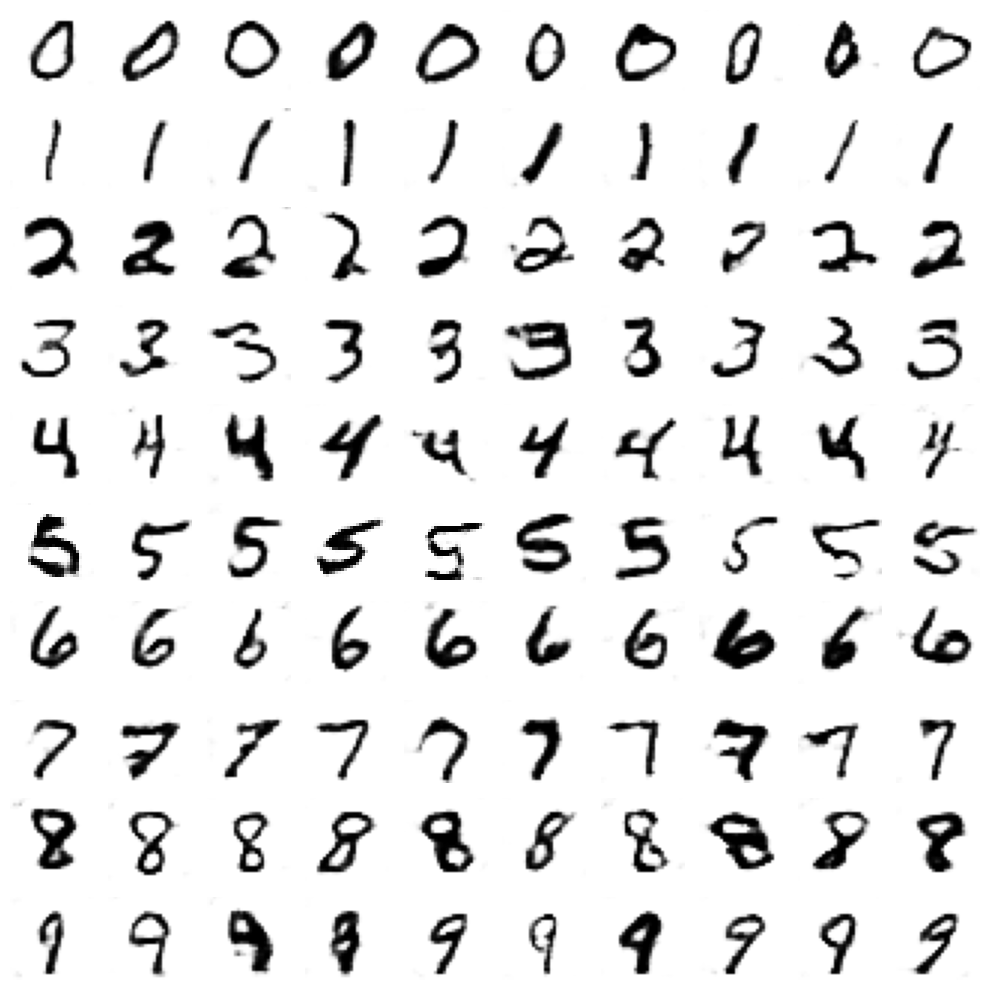

In [12]:
#Show examples of digit where first row is ones, second row is twos, etc.
noise = np.random.normal(0, 1, (100, sample_size))
label = np.arange(10).reshape(-1, 1)
label = np.repeat(label, 10, axis=0)
generated_images = generator.predict([noise, label])
generated_images = (generated_images * 127.5) + 127.5
    # # Show the images
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# generator.save("generator_cgan.keras")
# discriminator.save("discriminator_cgan.keras")